In [27]:
# Import libraries
from mido import MidiFile, MidiTrack

# Import file stuff
import os

# Import basic
import pandas as pd
import numpy as np

import mido
import matplotlib.pyplot as plt
import random

In [2]:
# Finding the notes, velocities, and duration from the midi file
def process_midi_file(filepath):
    # Create the midi object
    midi = MidiFile(filepath)

    # Empty lists to hold the values
    notes = []
    velocities = []
    durations = []

    # Iterate through the midi file via track
    # Tack is a list of messages and meta messages that we can pull from
    for track in midi.tracks:
        time = 0

        # Find the time when there is data
        for msg in track:
            time += msg.time
            
            # We only want to time it when the note is pressed
            if msg.type == 'note_on':
                notes.append(msg.note)
                velocities.append(msg.velocity)
                durations.append(time)
                time = 0
                
            # While there isn't a note played, continue through the track
            elif msg.type == 'note_off':
                time += msg.time

    return notes, velocities, durations

In [3]:
filepath = './Composer_Dataset/NN_midi_files_extended/dev/bach/bach344.mid'
notes, velocities, durations = process_midi_file(filepath)

In [4]:
def get_children(a_dir):
    dirs = []
    files = []
    for name in os.listdir(a_dir):
        if os.path.isdir(os.path.join(a_dir, name)):
            dirs.append(name)
        else:
            files.append(name)
    return [dirs,files]

def create_files_table(top_level, out_file):
    temp_comps = []
    temp_songs = []
    temp_paths = []
    
    composer_names, songs = get_children(top_level)

    for composer in composer_names:
        temp_path = top_level + '/' + composer
        temp, songs = get_children(temp_path)
        for song in songs:
            if song != '.DS_Store':
                temp_comps.append(composer)
                temp_paths.append(temp_path + '/' + song)
                temp_songs.append(song.split(".")[0])

    temp_dict = {'Composers': temp_comps, 'Songs': temp_songs, 'Paths': temp_paths}

    table = pd.DataFrame.from_dict(temp_dict)

    table.to_csv('./' + out_file + '.csv',index=False)
    
    return table

In [5]:
devpath = './Composer_Dataset/NN_midi_files_extended/dev/'
testpath = './Composer_Dataset/NN_midi_files_extended/test/'
trainpath = './Composer_Dataset/NN_midi_files_extended/train/'

dev_table = create_files_table(devpath, 'dev_table')
test_table = create_files_table(testpath, 'test_table')
train_table = create_files_table(trainpath, 'train_table')

In [6]:
dev_table.head()

,Composers,Songs,Paths
0,bach,bach344,./Composer_Dataset/NN_midi_files_extended/dev/...
1,bach,bach348,./Composer_Dataset/NN_midi_files_extended/dev/...
2,bach,bach354,./Composer_Dataset/NN_midi_files_extended/dev/...
3,bach,bach384,./Composer_Dataset/NN_midi_files_extended/dev/...
4,bartok,bartok410,./Composer_Dataset/NN_midi_files_extended/dev/...


In [7]:
def process_midi_file_enhanced(filepath, composer, song_name):
    # number of channels possible in midi file
    num_channels = 16
    midi = MidiFile(filepath)

    notes = []
    velocities = []
    start_note = []
    stop_note = []
    is_on = []
    channel = []

    for track in midi.tracks:
        time = np.zeros(num_channels)
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                notes.append(msg.note)
                velocities.append(msg.velocity)
                start_note.append(time[msg.channel])
                time[msg.channel] += msg.time
                stop_note.append(time[msg.channel])
                channel.append(msg.channel)
            if msg.type == 'note_on':
                is_on.append(1)
            elif msg.type == 'note_off':
                is_on.append(0)
    
    temp_dict = {'note': notes, 'velocity': velocities, 'start_note': start_note, 
             'stop_note': stop_note, 'is_on': is_on, 'channel': channel}
    temp_pd = pd.DataFrame.from_dict(temp_dict)
    temp_pd['composer'] = composer
    temp_pd['song_name'] = song_name

    return temp_pd

In [43]:
filepath = './Composer_Dataset/NN_midi_files_extended/dev/bach/bach348.mid'
midi = MidiFile(filepath)

In [44]:
msg= midi

In [10]:
exp = []
for row in dev_table.iterrows():
    temp_pd = process_midi_file_enhanced(row[1]['Paths'], row[1]['Composers'], row[1]['Songs'])
    exp.append(temp_pd)


In [11]:
df_final = pd.concat(exp,ignore_index=True)    

In [12]:
df_final

,note,velocity,start_note,stop_note,is_on,channel,composer,song_name
0,43,127,0.0,88.0,1,7,bach,bach344
1,62,127,0.0,177.0,1,2,bach,bach344
2,62,127,177.0,350.0,0,2,bach,bach344
3,64,127,0.0,5.0,1,4,bach,bach344
4,64,127,5.0,178.0,0,4,bach,bach344
...,...,...,...,...,...,...,...,...
221523,38,64,165376.0,165376.0,1,0,schumann,schumann238
221524,26,0,165376.0,166400.0,0,0,schumann,schumann238
221525,38,0,166400.0,166400.0,0,0,schumann,schumann238
221526,66,0,166400.0,166912.0,0,0,schumann,schumann238


In [13]:
df_final.iloc[df_final['stop_note'].idxmax()] 

note                 66
velocity            119
start_note    1402800.0
stop_note     1402920.0
is_on                 0
channel               0
composer         hummel
song_name     hummel327
Name: 129480, dtype: object

In [15]:
df_final.to_csv('./notes_table_dev.csv')

In [19]:
#msg

df_final.iloc[df_final['channel'].idxmax()] 

note                      43
velocity                  45
start_note               0.0
stop_note             3120.0
is_on                      1
channel                   15
composer         mendelssohn
song_name     mendelssohn265
Name: 152472, dtype: object

In [20]:
df_final.iloc[df_final['channel'].idxmin()] 

note               72
velocity          127
start_note        0.0
stop_note         4.0
is_on               1
channel             0
composer         bach
song_name     bach344
Name: 37, dtype: object

In [45]:
msg


MidiFile(type=0, ticks_per_beat=384, tracks=[
  MidiTrack([
    MetaMessage('copyright', text='(C) John Sankey 1998', time=0),
    Message('program_change', channel=0, program=6, time=0),
    Message('pitchwheel', channel=0, pitch=0, time=0),
    Message('program_change', channel=1, program=6, time=0),
    Message('pitchwheel', channel=1, pitch=-400, time=0),
    Message('program_change', channel=2, program=6, time=0),
    Message('pitchwheel', channel=2, pitch=-316, time=0),
    Message('program_change', channel=3, program=6, time=0),
    Message('pitchwheel', channel=3, pitch=-240, time=0),
    Message('program_change', channel=4, program=6, time=0),
    Message('pitchwheel', channel=4, pitch=-400, time=0),
    Message('program_change', channel=5, program=6, time=0),
    Message('pitchwheel', channel=5, pitch=-80, time=0),
    Message('program_change', channel=6, program=6, time=0),
    Message('pitchwheel', channel=6, pitch=-480, time=0),
    Message('program_change', channel=7, pro

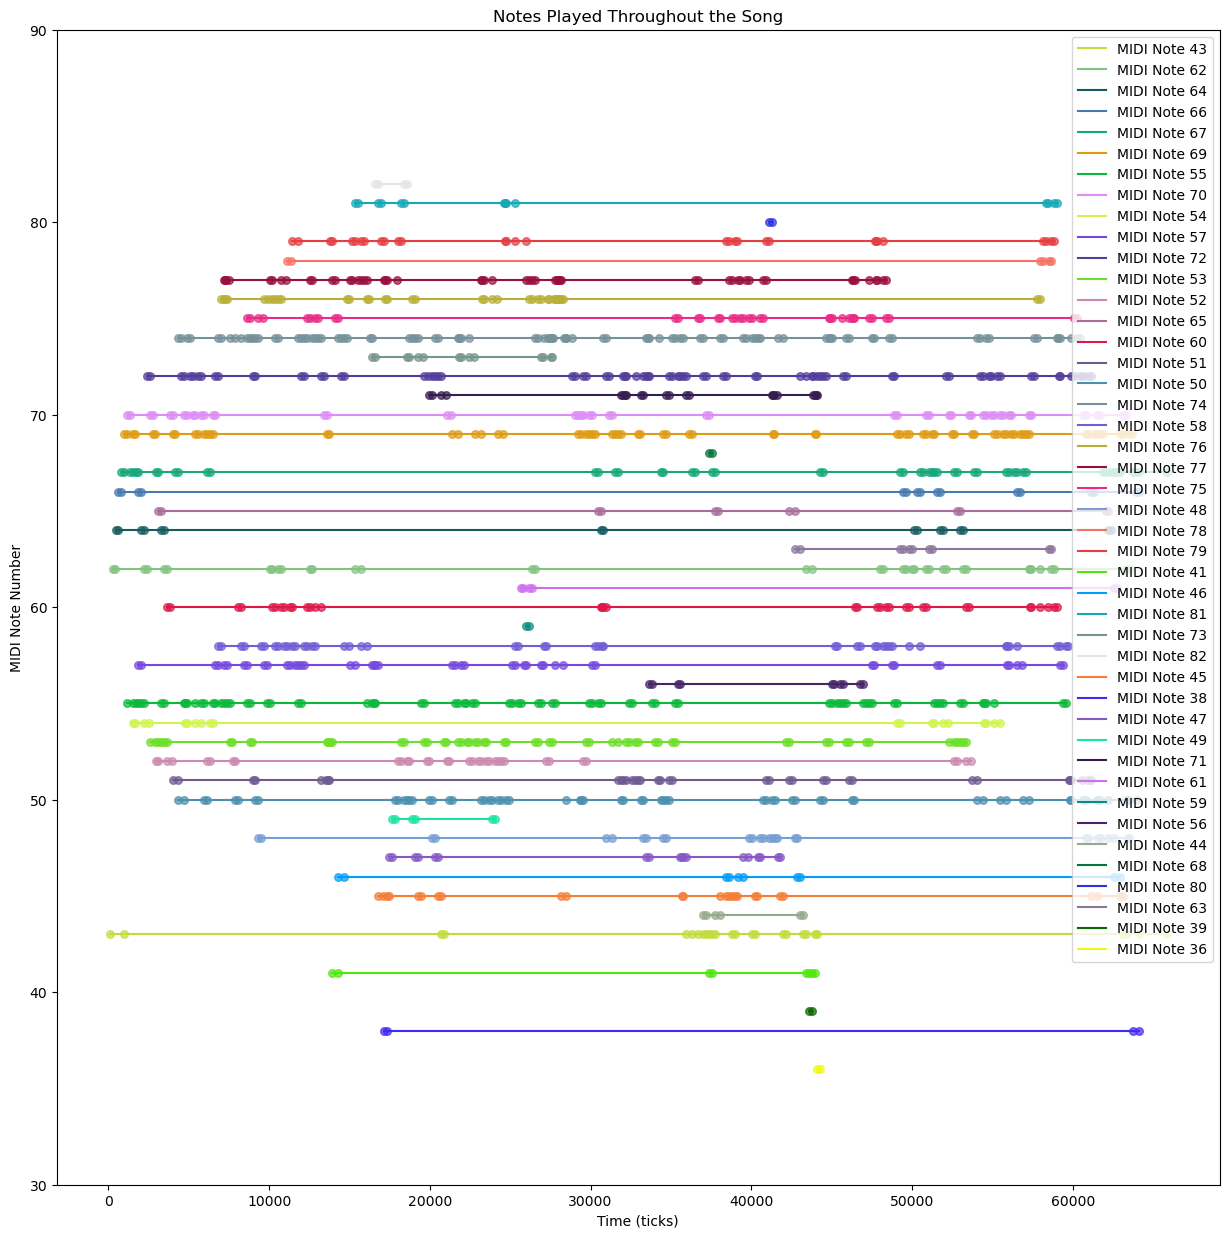

In [30]:
# Function to extract the notes played in a MIDI file with timestamps
def extract_notes_with_time(midi_filepath):
    notes = {}
    midi = mido.MidiFile(midi_filepath)
    
    for track in midi.tracks:
        time_counter = 0
        for msg in track:
            time_counter += msg.time
            
            if msg.type == 'note_on':
                if msg.velocity != 0:  # Ensure it's a Note On event
                    notes[msg.note] = notes.get(msg.note, []) + [(time_counter, 1)]  # 1 represents Note On
            elif msg.type == 'note_off':
                notes[msg.note] = notes.get(msg.note, []) + [(time_counter, 0)]  # 0 represents Note Off

    return notes

# Function to plot the notes played in a MIDI file with timestamps
def plot_notes_played_with_time(notes):
    plt.figure(figsize=(15, 15))

    # Generate random colors for each note
    color_map = {}
    for note in notes.keys():
        color_map[note] = (random.random(), random.random(), random.random())

    for note, events in notes.items():
        times, status = zip(*events)
        plt.step(times, [note] * len(times), where='post', color=color_map[note], label=f'MIDI Note {note}')
        plt.scatter(times, [note] * len(times), color=color_map[note], marker='o', s=30, alpha=0.7)

    plt.xlabel('Time (ticks)')
    plt.ylabel('MIDI Note Number')
    plt.title('Notes Played Throughout the Song')
    plt.legend(loc='upper right')
    plt.ylim(30, 90)  # Adjust the y-axis range as per your MIDI notes range
    plt.show()

# Example usage:
midi_file_path = './Composer_Dataset/NN_midi_files_extended/dev/bach/bach344.mid'
notes_with_time = extract_notes_with_time(midi_file_path)
plot_notes_played_with_time(notes_with_time)

In [34]:
notes_with_time

{43: [(88, 1),
  (975, 0),
  (20681, 1),
  (20854, 0),
  (35949, 1),
  (36299, 0),
  (36660, 1),
  (37010, 0),
  (37192, 1),
  (37365, 0),
  (37547, 1),
  (37720, 0),
  (38790, 1),
  (38963, 0),
  (40032, 1),
  (40205, 0),
  (41985, 1),
  (42158, 0),
  (43228, 1),
  (43401, 0),
  (43938, 1),
  (44111, 0),
  (63140, 1),
  (63322, 0),
  (64149, 1),
  (65846, 0)],
 62: [(265, 1),
  (438, 0),
  (2219, 1),
  (2392, 0),
  (3460, 1),
  (3633, 0),
  (10030, 1),
  (10203, 0),
  (10562, 1),
  (10735, 0),
  (12515, 1),
  (12688, 0),
  (15356, 1),
  (15688, 0),
  (26362, 1),
  (26535, 0),
  (43405, 1),
  (43755, 0),
  (48021, 1),
  (48194, 0),
  (49441, 1),
  (49614, 0),
  (49974, 1),
  (50147, 0),
  (50861, 1),
  (51034, 0),
  (51927, 1),
  (52100, 0),
  (53170, 1),
  (53343, 0),
  (57253, 1),
  (57337, 0),
  (57430, 1),
  (57934, 0),
  (58673, 1),
  (58846, 0),
  (63326, 1),
  (63566, 0)],
 64: [(443, 1),
  (616, 0),
  (2040, 1),
  (2213, 0),
  (3283, 1),
  (3456, 0),
  (30623, 1),
  (30796, 0),